![](https://raw.githubusercontent.com/fdannemanndugick/roses2021/main/header.png)

# Obtaining metadata and experimenting with response removal
The goal of this exercise is to explore different options in ObsPy's remove_response method and how they affect the output signal after deconvolution. Explore lots of different options, change the settings to request data from a station and earthquake of interest to you, and remember you can always re-start the notebook!  

You may want to start by taking a look at the documentation for remove_response: https://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.remove_response.html

We'll start with the usual imports:

In [1]:
import obspy
from obspy.clients.fdsn import Client

# Edit client to use your data center of interest
client = Client("IRIS")


List of available clients: https://docs.obspy.org/packages/obspy.clients.fdsn.html

In [2]:
# Edit this to request metadata from your favorite station(s)
t1 = obspy.UTCDateTime("2020-07-01")
inv = client.get_stations(network="IW", station="PLID", channel="BHZ", level="response", starttime=t1)
inv += client.get_stations(network="GS", station="PR01", channel="HHZ", level="response", starttime=t1)
# may get a warning about StationXML1.1 -- OK to ignore it

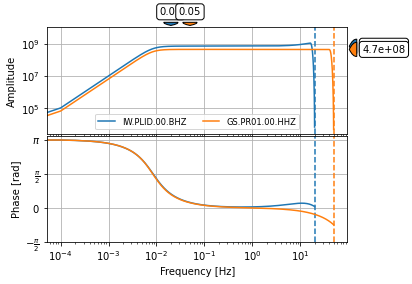

Inventory created at 2021-06-26T12:53:55.785363Z
	Created by: ObsPy 1.2.2
		    https://www.obspy.org
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (2):
			GS, IW
		Stations (2):
			GS.PR01 (PR01, Lajas)
			IW.PLID (Pearl Lake, Idaho, USA)
		Channels (2):
			GS.PR01.00.HHZ, IW.PLID.00.BHZ


/home/kdavidson/anaconda3/envs/roses/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/home/kdavidson/anaconda3/envs/roses/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_ocean.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/home/kdavidson/anaconda3/envs/roses/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/home/kdavidson/anaconda3/envs/roses/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloa

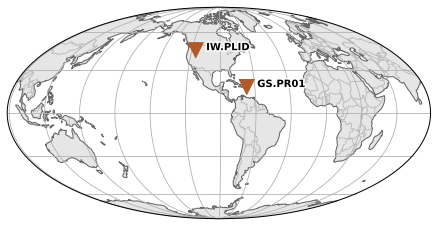

In [3]:
inv.plot_response(min_freq=1e-4)
inv.write("inventory.xml", format="stationxml")
print(inv)
inv.plot();

Let's revisit the example Sydney showed in Unit 1 using the 2019 M7.1 Ridgecrest earthquake and GSN station IU.TUC in Tucson, Arizona.

1 Trace(s) in Stream:
IU.TUC.00.HH1 | 2019-07-06T03:18:53.048393Z - 2019-07-06T03:34:53.038393Z | 100.0 Hz, 96000 samples


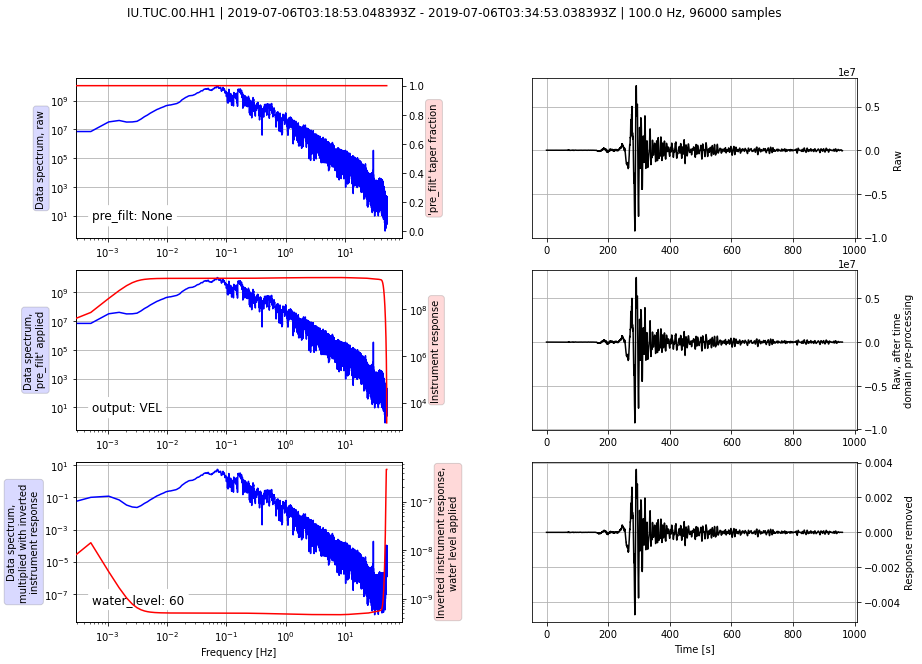

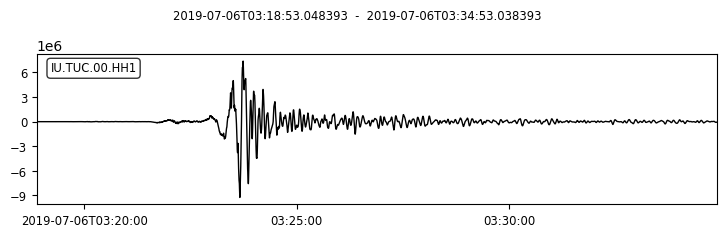

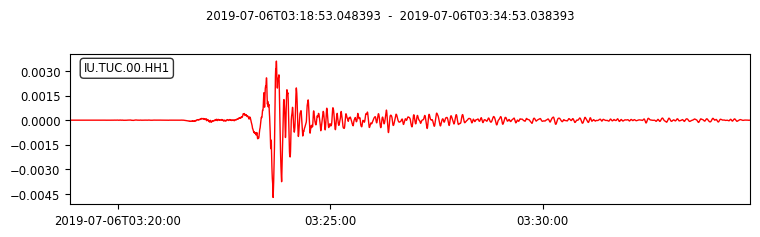

In [4]:
time = obspy.UTCDateTime("2019-07-06T03:19:53.04")
starttime = time - 60 
endtime = time + 60*15

net = "IU"
sta = "TUC"
loc = "00"
chan = "HH1"

# Requesting waveforms with attach_response=True tells ObsPy to request an inventory object for the channels requested
# st. 
st = client.get_waveforms(net, sta, loc, chan, starttime, endtime, attach_response = True)
print(st)

st_rem = st.copy() # make a copy of our original stream so we can try different options later

st_rem.remove_response(output = 'VEL', plot = True, water_level = 60) # Use ObsPy defaults to remove response
# What happens if you choose a different water_level?  What if you set water_level = 0?

st.plot()
st_rem.plot(color='red');

# Remember, if you remove the response from the same trace multiple times, your output will be strange (and non-physical).  
# This is why we make a new copy of st for each example below. 

By default, ObsPy removes the mean of the signal and applies a 5% cosine taper to the ends of the signal before removing the response: https://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.remove_response.html

Let's explore what happens if we don't remove the mean or taper the signal. We'll also add a larger offset to the data to mimic a seismometer with masses that have drifted off-center (a common occurrence).

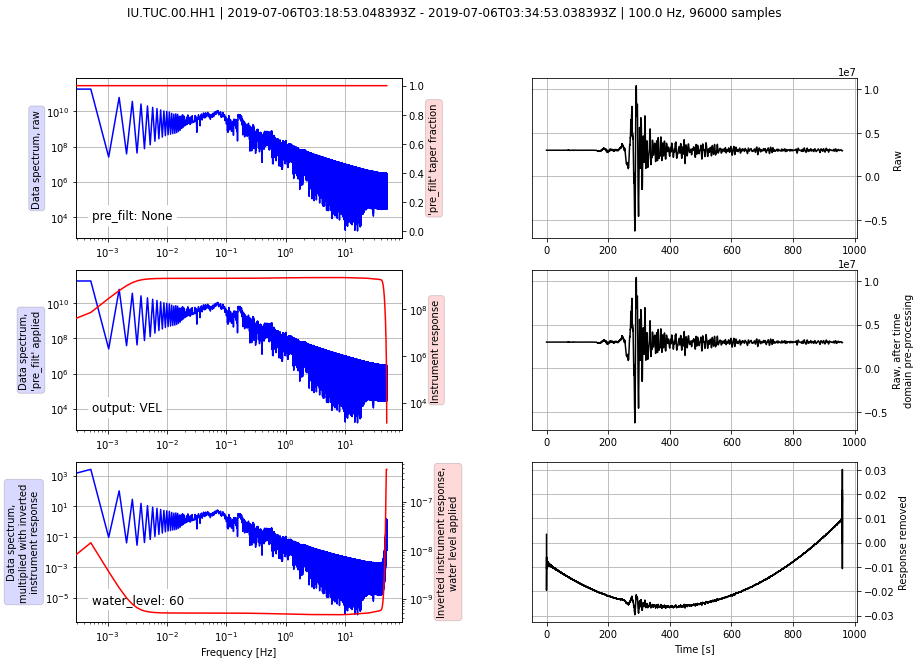

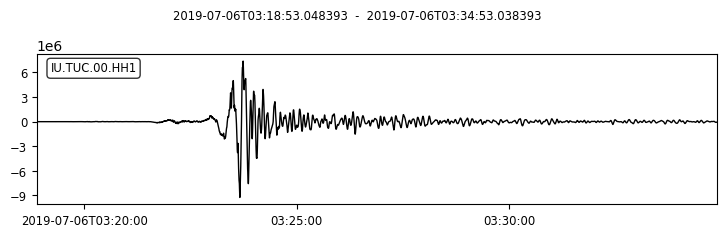

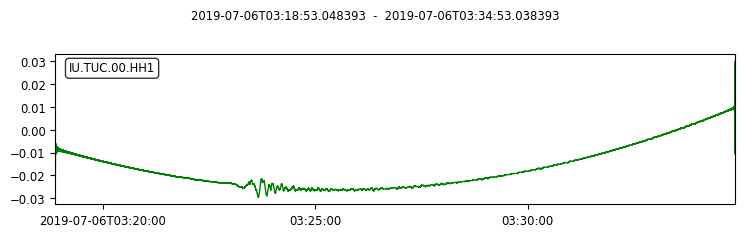

In [5]:
st_rem = st.copy() # repeating this since the last cell will have removed the response from st_rem already

# ObsPy's remove_response command automatically removes the mean and applies a 5% taper
# This supresses low and high-frequency artifacts 
# What happens if you turn these off? 
# Let's add a big offset to the data to exaggerate the effects
st_rem[0].data = st_rem[0].data + 3e6
st_rem.remove_response(output = 'VEL', plot = True, taper=0, zero_mean=False) 

st.plot()
st_rem.plot(color='green');


You can also use the pre_filt option to apply a filter to your data before removing the response. This helps stabilize the deconvolution and avoids blowing up long-period noise.

100.0


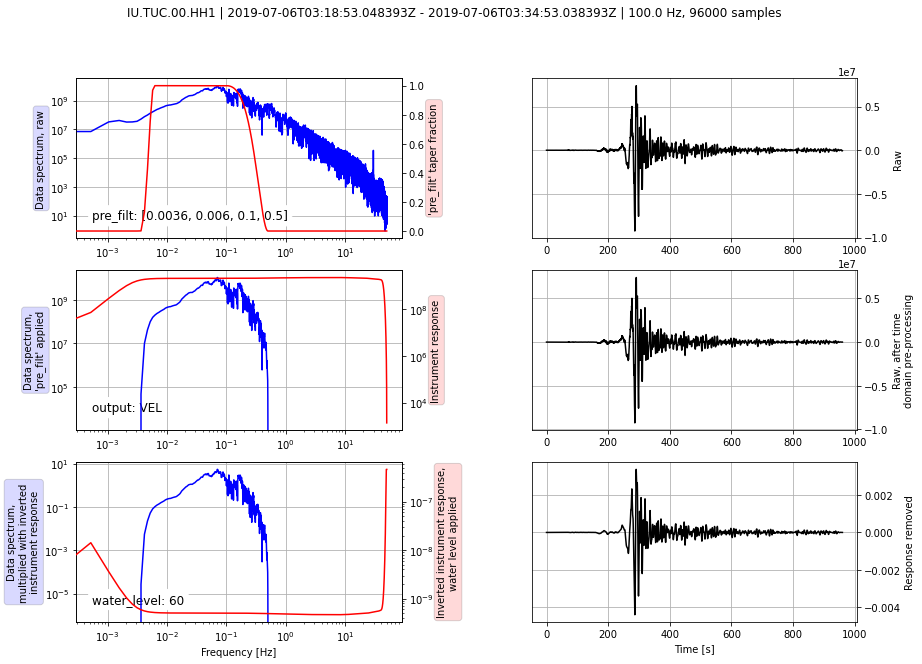

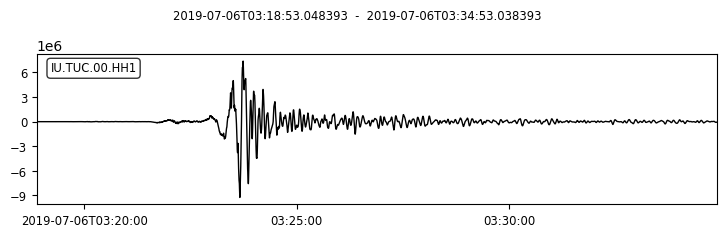

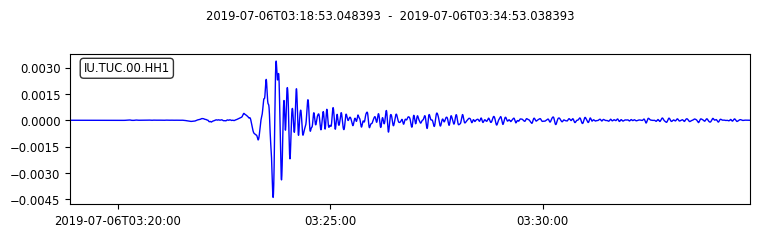

In [6]:
st_rem = st.copy() # repeating this since the last cell will have removed the response from st_rem already

# Use pre_filt command to filter the signal in your frequency band of interest
# Here's an example with pre_filt parameters useful for surface-wave studies
# Experiment with changing the 4 frequencies to see how this modifies the red pre_filt curve in the first row of plots
# Try modifying it to a frequency band that emphasizes body waves (~1 s) and filters out surface waves (~10s-100s of sec)
# Note: pre_filt is specified in Hz
# Remember: best not to work too close to Nyquist (highest freq should be no higher than about 0.75*fny)
print(st_rem[0].stats.sampling_rate)
st_rem.remove_response(output = 'VEL', plot = True, pre_filt=[0.0036, 0.006, 0.1, 0.5]) 

st.plot()
st_rem.plot(color='blue');

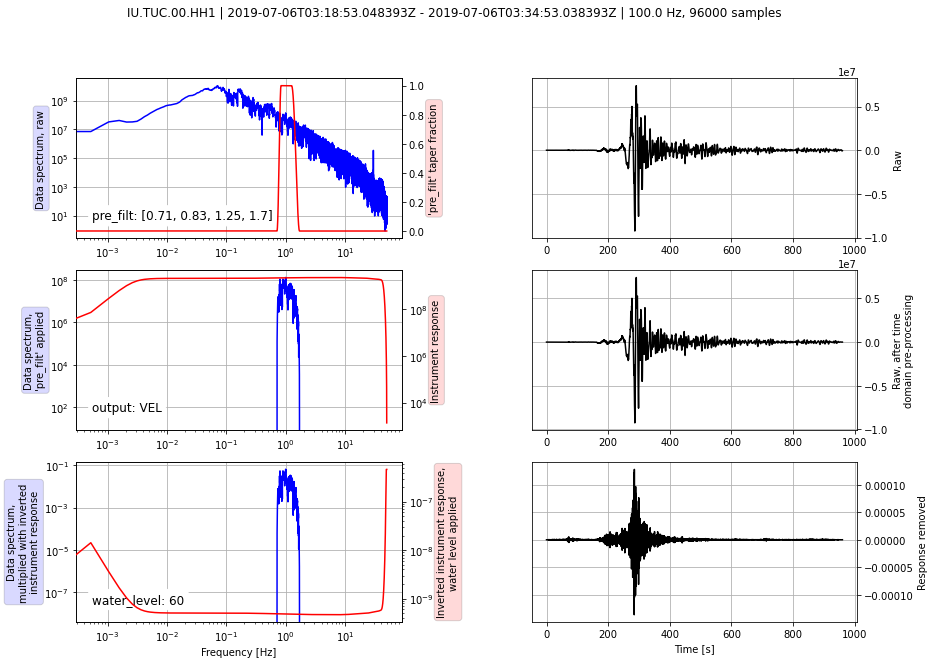

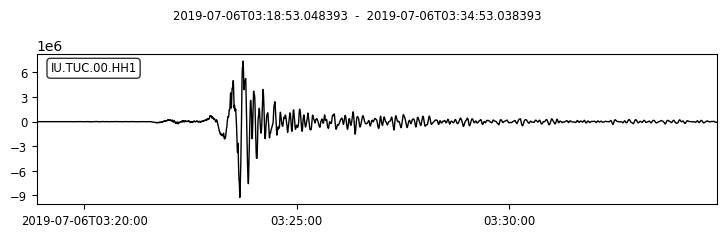

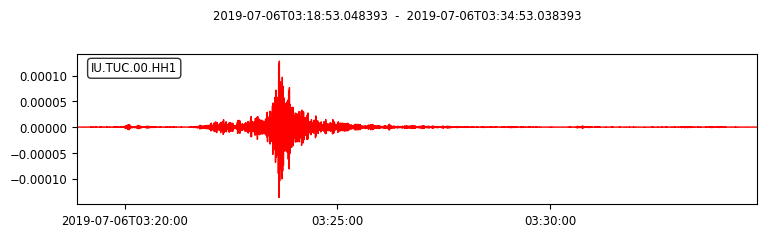

In [15]:
# Body wave example, filter around 1 second
st_bw = st.copy()
st_bw.remove_response(output = 'VEL', plot = True, pre_filt=[0.71, 0.83, 1.25, 1.7])

st.plot()
st_bw.plot(color='red');

## Additional example from my research

One of the marsquakes detected by the NASA [InSight Mission.](http://ds.iris.edu/mda/XB/#XB_2016-01-01_2023-01-01)

In [8]:
# set up client parameters to get the waveforms
client = Client("IRIS")
network = "XB"
station = "ELYSE"
location = "02"
channel = "BH?"

In [9]:
# set start and end times
from obspy import UTCDateTime
starttime = UTCDateTime("2019-07-26T12:10")
endtime = UTCDateTime("2019-07-26T13:30")

In [15]:
# get the waveforms
mars_stream = client.get_waveforms(network,
                                   station,
                                   location,
                                   channel,
                                   starttime,
                                   endtime,
                                   attach_response=True)

# write the waveforms to a local file
mars_stream.write(network + '_' + station + '_waveforms.mseed', format='MSEED')

In [16]:
# take a backup in memory in case things go wrong
mars_stream_backup = mars_stream.copy();

In [17]:
# check the stream
mars_stream

3 Trace(s) in Stream:
XB.ELYSE.02.BHU | 2019-07-26T12:10:00.008000Z - 2019-07-26T13:30:00.008000Z | 20.0 Hz, 96001 samples
XB.ELYSE.02.BHV | 2019-07-26T12:10:00.008000Z - 2019-07-26T13:30:00.008000Z | 20.0 Hz, 96001 samples
XB.ELYSE.02.BHW | 2019-07-26T12:10:00.009000Z - 2019-07-26T13:30:00.009000Z | 20.0 Hz, 96001 samples

In [18]:
# inventory is attached
mars_stream[0].stats

               network: XB
               station: ELYSE
              location: 02
               channel: BHU
             starttime: 2019-07-26T12:10:00.008000Z
               endtime: 2019-07-26T13:30:00.008000Z
         sampling_rate: 20.0
                 delta: 0.05
                  npts: 96001
                 calib: 1.0
_fdsnws_dataselect_url: http://service.iris.edu/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'M', 'number_of_records': 223, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 344064})
            processing: ['ObsPy 1.2.2: trim(endtime=UTCDateTime(2019, 7, 26, 13, 30, 0, 8000)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2019, 7, 26, 12, 10, 0, 8000))']
              response: Channel Response
	From m/s (VELOCITY in Meters Per Second) to counts (DIGITAL UNIT in Counts)
	Overall Sensitivity: 8.62622e+10 defined at 0.100 Hz
	5 stages:
		Stage 1: PolesZ

In [25]:
# Can get the metadata separately if needed
mars_inventory = client.get_stations(starttime,
                                     endtime,
                                     network = network,
                                     station = station,
                                     location = location,
                                     channel = channel,
                                     level = "response")
print(mars_inventory)
mars_inventory.write(network + '_' + station + '_metadata.xml', format="stationxml")

Inventory created at 2021-06-26T13:25:37.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.47
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2019-07-26...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			XB
		Stations (1):
			XB.ELYSE (Elysium Planitia, Mars - Scientific data)
		Channels (3):
			XB.ELYSE.02.BHU, XB.ELYSE.02.BHV, XB.ELYSE.02.BHW


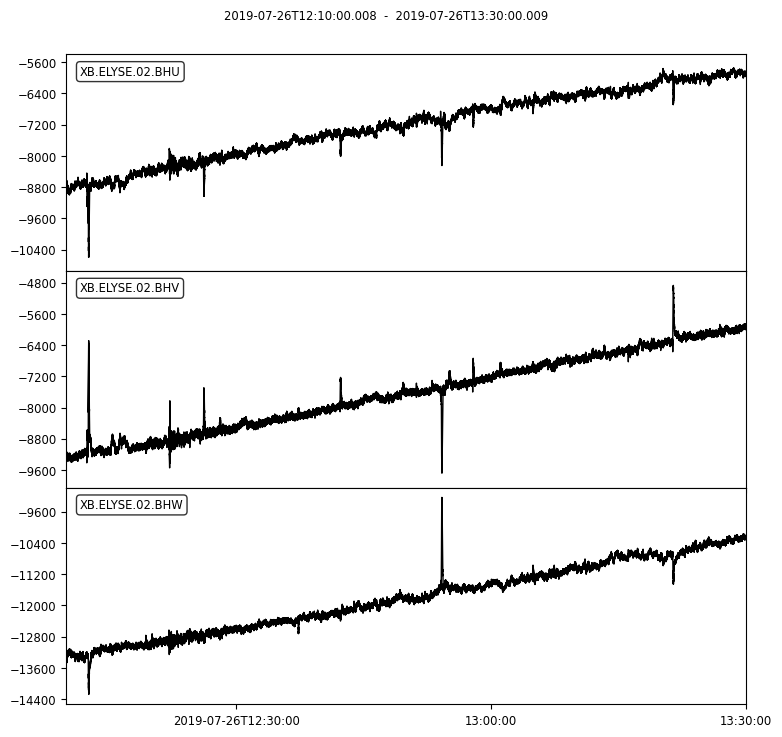

In [27]:
# view the raw waveforms
mars_stream_raw = mars_stream.copy()
mars_stream_raw.plot();

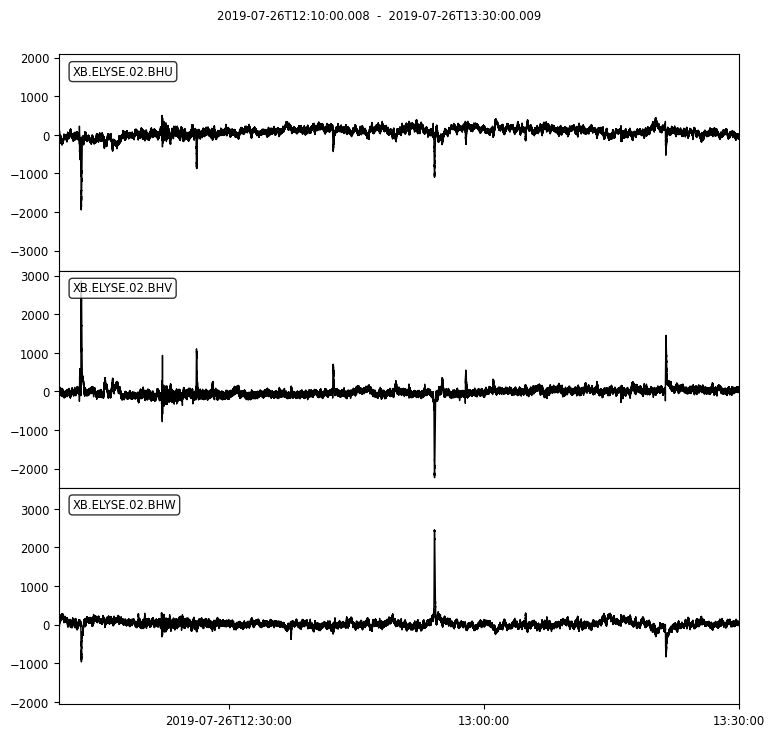

In [28]:
# remove the trend
mars_stream_detrend = mars_stream.copy()
for tr in mars_stream_detrend:
    tr.detrend()
mars_stream_detrend.plot();

In [50]:
# Remove the instrument response.
# Take a copy of one trace and work on this to establish parameters.
test_trace = mars_stream_detrend[0].copy()
print(test_trace)

XB.ELYSE.02.BHU | 2019-07-26T12:10:00.008000Z - 2019-07-26T13:30:00.008000Z | 20.0 Hz, 96001 samples


In [51]:
# Define parameters for the removal
output = 'VEL'                        # we see this in the metadata
pre_filt = [0.05, 0.07, 0.7, 1.1]     # narrow band; Mars is noisy

XB.ELYSE.02.BHU | 2019-07-26T12:10:00.008000Z - 2019-07-26T13:30:00.008000Z | 20.0 Hz, 96001 samples

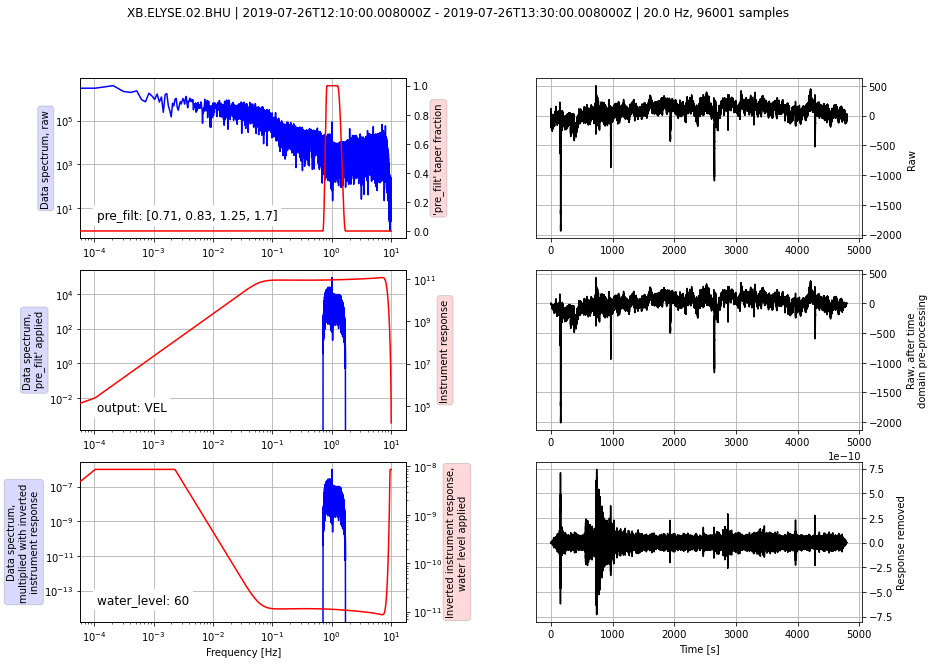

In [52]:
test_trace.remove_response(output = output, pre_filt = pre_file, plot=True)

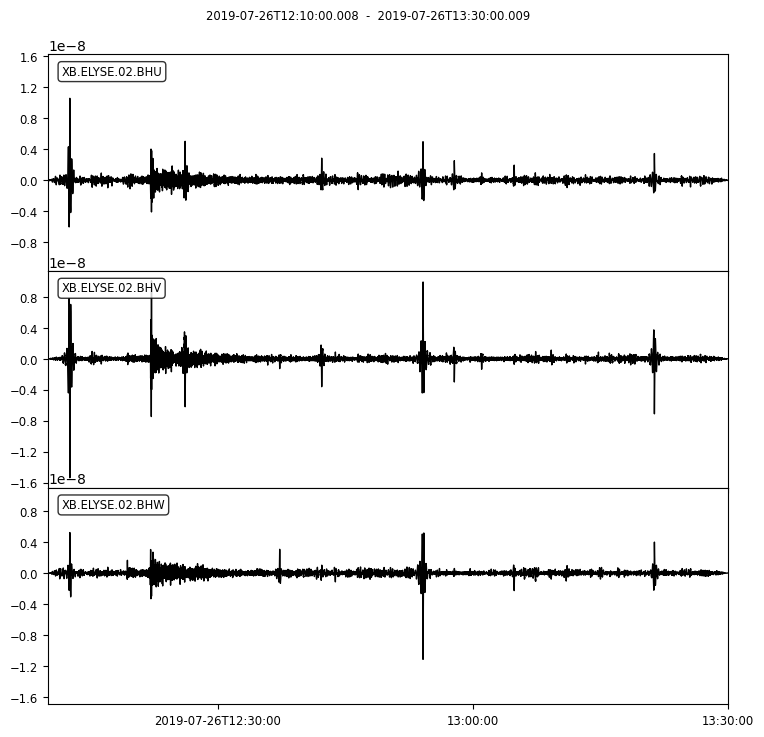

In [53]:
# Apply to the whole stream
mars_resp_rem = mars_stream_detrend.copy()
mars_resp_rem.remove_response(output=output, pre_filt=pre_filt)
mars_resp_rem.plot();

We can see from the channel names that the sesimometer on InSight does not record in XYZ co-ordinates. It is a Galperin configuration, as used in boreholes.

The orientation of each sensor is recorded in the metadata.

In [65]:
mars_inventory[0].get_orientation("XB.ELYSE.02.BHW")

{'azimuth': 255.0, 'dip': -29.7}

This came up as a question during the lecture - we can use the metadata information and the ObsPy `rotate()` method to align the sensors to ZNE.

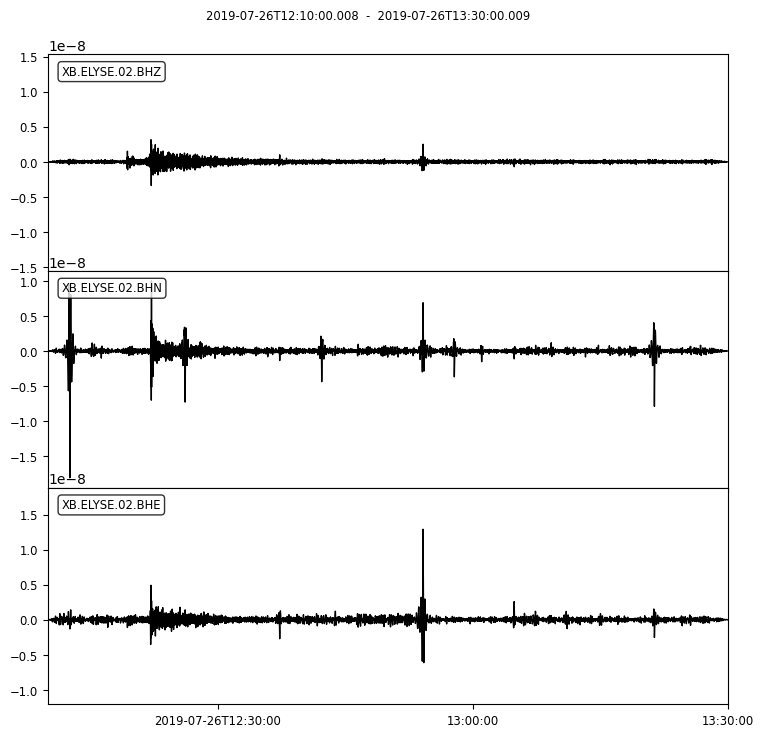

In [66]:
mars_stream_rotate = mars_resp_rem.copy()
mars_stream_rotate.rotate(method='->ZNE', inventory=mars_inventory, components="UVW")
mars_stream_rotate.plot();